In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import radians, degrees, cos, sin, asin, sqrt

from scipy.stats import hmean

from tqdm import tqdm_notebook as tqdm

import feather

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

import keras
from keras.preprocessing import sequence
from keras import layers, Input, Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, LSTM, Dropout

from pathlib import Path


Using TensorFlow backend.


In [2]:
messages = pd.read_csv("../../Trapeze_Data/Extract 20180918_20181216/VehicleMessages.csv", dtype={"isValid":float, "workCode":float,"tripCode":float}, parse_dates=[1], infer_datetime_format=True)


In [218]:
se = feather.read_dataframe("../../data_files/B/once/75days/stop_events_with_geo_train_test_averages_prev_next_dwell.feather",
                            columns=["index",
                                     "segment_duration",
                                     "mean_durations_by_segment_code",
                                     "mean_durations_by_segment_code_and_hour",
                                     "mean_durations_by_segment_code_and_hour_and_day",
                                     "diff_segment_and_mean_by_segment_code",
                                     "diff_segment_and_mean_by_segment_code_and_hour_and_day",
                                     'line_distance',
                                     'to_centre_dist',
                                     'direction_degrees',
                                     'rain',
                                     'median_durations_by_segment_code_and_hour_and_day',
                                     'arrival_hour','arrival_day',
                                     "diff_percent_segment_and_mean_by_segment_code_and_hour_and_day",
                                     'date','workid',
                                     'actualArrival',
                                     'publicName',
                                     'segment_name',
                                     'prev_segment_code_1',
                                     'next_segment_code_1'
                                    ])
se = se.set_index(se.columns[0])

In [219]:
se['speed_mph'] = se['line_distance']*1000/se['segment_duration'] * 2.237

# And now for just segments:
se["diff_segment_and_mean_by_segment_code"] = (
    se["segment_duration"]
    - se["mean_durations_by_segment_code"]
)
se["diff_segment_and_mean_by_segment_code_and_hour_and_day"] = (
    se["segment_duration"]
    - se["mean_durations_by_segment_code_and_hour_and_day"]
)

se["diff_percent_segment_and_mean_by_segment_code"] = (
    se["diff_segment_and_mean_by_segment_code"]
    * 100
    / se["mean_durations_by_segment_code"]
)

se["diff_percent_segment_and_mean_by_segment_code_and_hour_and_day"] = (
    se["diff_segment_and_mean_by_segment_code_and_hour_and_day"]
    * 100
    / se["mean_durations_by_segment_code_and_hour_and_day"]
)

In [228]:
se['prev_segment_name'] = se['prev_segment_code_1'].str[:-2]
se['next_segment_name'] = se['next_segment_code_1'].str[:-2]

In [4]:
messages.dtypes

vehicle                  int64
timeReported    datetime64[ns]
msg                     object
lon                    float64
lat                    float64
bearing                float64
isValid                float64
stopCode                object
workCode               float64
tripCode               float64
dtype: object

In [5]:
messages

,vehicle,timeReported,msg,lon,lat,bearing,isValid,stopCode,workCode,tripCode
0,113,2018-09-18 07:26:16,inPosition,-1.836883,50.753617,192.0,1.0,NaN,NaN,NaN
1,113,2018-09-18 07:26:46,inPosition,-1.836883,50.753600,192.0,1.0,NaN,NaN,NaN
2,113,2018-09-18 07:27:16,inPosition,-1.836883,50.753600,192.0,1.0,NaN,NaN,NaN
3,113,2018-09-18 07:27:46,inPosition,-1.836933,50.753600,192.0,1.0,NaN,NaN,NaN
4,113,2018-09-18 07:28:16,inPosition,-1.836967,50.753617,192.0,1.0,NaN,NaN,NaN
5,113,2018-09-18 07:28:46,inPosition,-1.837000,50.753617,192.0,1.0,NaN,NaN,NaN
6,113,2018-09-18 07:29:16,inPosition,-1.837083,50.753600,192.0,1.0,NaN,NaN,NaN
7,113,2018-09-18 07:29:46,inPosition,-1.837083,50.753617,192.0,1.0,NaN,NaN,NaN
8,113,2018-09-18 07:30:16,inPosition,-1.837050,50.753633,192.0,1.0,NaN,NaN,NaN
9,113,2018-09-18 07:30:46,inPosition,-1.837067,50.753617,192.0,1.0,NaN,NaN,NaN


In [6]:
messages['delta_time'] = messages['timeReported'] - messages.shift(1)['timeReported']
messages['time_seconds'] = messages['delta_time'] / np.timedelta64(1, 's')

/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


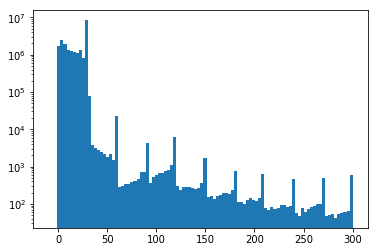

In [7]:
plt.hist((messages['delta_time'] / np.timedelta64(1, 's')).values, bins=100, range=(-10, 300));
plt.yscale("log")
plt.show()

In [8]:
print(f"Fraction under 31 seconds: {np.count_nonzero(messages['time_seconds'] < 31)/messages.shape[0]}")
      
print(f"Between 20 and 31 seconds: {np.count_nonzero((messages['time_seconds'] < 31) & (messages['time_seconds'] > 20))/messages.shape[0]}")
      
print(f"Between 10 and 31 seconds: {np.count_nonzero((messages['time_seconds'] < 31) & (messages['time_seconds'] > 10))/messages.shape[0]}")
      
print(f"Between 5 and 31 seconds: {np.count_nonzero((messages['time_seconds'] < 31) & (messages['time_seconds'] > 5))/messages.shape[0]}")
      

Fraction under 31 seconds: 0.9922608936229077
Between 20 and 31 seconds: 0.4860636787015263
Between 10 and 31 seconds: 0.6677617927790842
Between 5 and 31 seconds: 0.7985293032692397


In [9]:
messages['delta_lon'] = messages['lon'] - messages.shift(1)['lon']
messages['delta_lat'] = messages['lat'] - messages.shift(1)['lat']

In [10]:
messages['msg'].unique()

array(['inPosition', 'InTripEnd', 'InTripStart', 'InPointArrive',
       'InPointDepart'], dtype=object)

In [11]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [12]:
messages['delta_distance'] = haversine_np(messages['lon'], messages['lat'], messages['lon'].shift(1), messages['lat'].shift(1)) * 1000

In [13]:
messages['delta_speed'] = messages['delta_distance']/(messages['delta_time'] / np.timedelta64(1, 's'))

In [14]:
messages['speed_mph'] = messages['delta_speed'] * 2.237

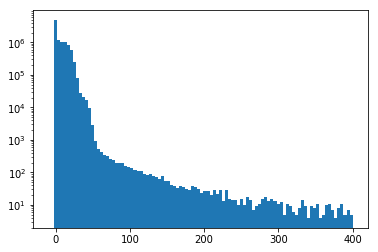

In [15]:
plt.hist(messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['time_seconds'] < 31) & (messages['time_seconds'] > 20)]['speed_mph'], bins=100, range=(-10,400));
plt.yscale("log")

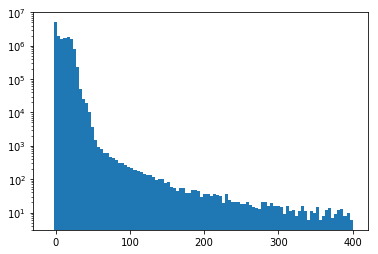

In [16]:
plt.hist(messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['time_seconds'] < 31) & (messages['time_seconds'] > 5)]['speed_mph'], bins=100, range=(-10,400));
plt.yscale("log")

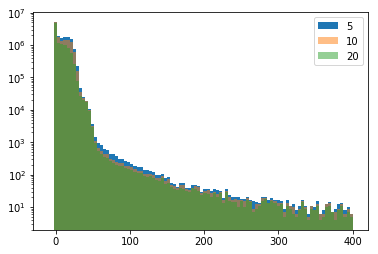

In [17]:
plt.hist(messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['time_seconds'] < 31) & (messages['time_seconds'] > 5)]['speed_mph'], bins=100, range=(-10,400), label="5");
plt.hist(messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['time_seconds'] < 31) & (messages['time_seconds'] > 10)]['speed_mph'], bins=100, range=(-10,400), label="10", alpha=0.5);
plt.hist(messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['time_seconds'] < 31) & (messages['time_seconds'] > 20)]['speed_mph'], bins=100, range=(-10,400), label="20", alpha=0.5);
plt.yscale("log")
plt.legend()

In [18]:
messages['prev_speed_mph'] = messages.shift(1)['speed_mph']
messages['next_speed_mph'] = messages.shift(-1)['speed_mph']

In [19]:
messages['jitter'] = [False]*messages.shape[0]

messages['jitter'] = (messages['speed_mph'] > 75) & \
    (((messages['prev_speed_mph'] > 75) & (messages['next_speed_mph'] < 50)) | \
     ((messages['next_speed_mph'] > 75) & (messages['prev_speed_mph'] < 50)))

In [20]:
filtered = messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['time_seconds'] < 31) & (messages['time_seconds'] > 5) & (messages['jitter'] == False) & (messages['speed_mph'] != np.inf)]


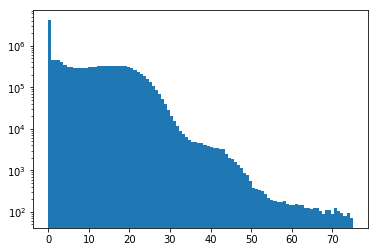

In [21]:
plt.hist(filtered['speed_mph'], bins=100, range=(0,75));
plt.yscale("log")

In [22]:
hourly_averages = filtered.groupby(filtered['timeReported'].dt.hour).mean()

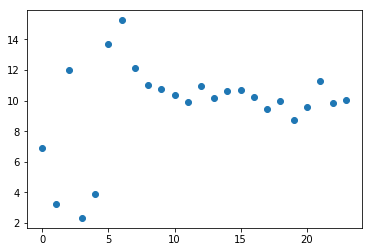

In [23]:
plt.scatter(hourly_averages.index, hourly_averages['speed_mph'])

In [24]:
filtered['segment_name'] = filtered['stopCode'].fillna(method="ffill") + "_" + filtered['stopCode'].fillna(method="bfill") 

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
# pop_segments = filtered.groupby('segment_name').count()

In [26]:
# popular_segment_names = pop_segments.sort_values('isValid', ascending=False).index

In [27]:
# plt.hist(filtered[filtered['segment_name'] == "1290BOB20384_1290BOB20449"]['speed_mph'], bins=100, range=(0,75));

In [28]:
def cal_stats():
    
    segments = filtered.groupby('segment_name')
    
    all_stats = []
    
    for segment_name, segment in tqdm(segments):
        
        hours = []
        slow_percent = []
        fast_hmean = []
        fast_mean = []
        total_mean = []
        clipped_hmean = []
        clipped_mean = []
        freq_list = []
        seg_name = []
        
        segment_weeks = segment[segment['timeReported'].dt.dayofweek < 5]
        
        for hour, relevant in segment_weeks.groupby(segment_weeks['timeReported'].dt.hour):

            hours.append(hour)
            seg_name.append(segment_name)

#             relevant = segment[(segment['timeReported'].dt.hour == i) & (segment['timeReported'].dt.dayofweek < 5)]
#             if len(relevant) == 0:
#                 slow_percent.append(0)
#                 fast_hmean.append(0)
#                 fast_mean.append(0)
#                 total_mean.append(0)
#                 clipped_hmean.append(0)
#                 clipped_mean.append(0)
#                 freq_list.append(0)
#                 continue

            slow_count = np.count_nonzero(relevant['speed_mph'] < 3)
            fast = relevant[(relevant['speed_mph'] > 3)]['speed_mph'].values
            clipped = relevant[(relevant['speed_mph'] > 3) & (relevant['speed_mph'] < 31)]['speed_mph'].values

            slow_percent.append(slow_count/len(relevant))
            fast_hmean.append(hmean(fast))
            fast_mean.append(np.mean(fast))
            total_mean.append(np.mean(relevant['speed_mph']))
            clipped_hmean.append(hmean(clipped))
            clipped_mean.append(np.mean(clipped))
            freq_list.append(len(relevant))

        all_stats.append(pd.DataFrame(index=hours, data={'hours':hours, 'slow_fraction':slow_percent, 
                                                  'fast_mean':fast_mean, 'total_mean':total_mean, 
                                                  'clipped_hmean':clipped_hmean, 'clipped_mean':clipped_mean,
                                                  'freq':freq_list, 'fast_hmean':fast_hmean, 'seg_name':seg_name }))
        
    return pd.concat(all_stats)
        

In [29]:
all_stats_df = cal_stats()

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/scipy/stats/stats.py:377: RuntimeWarning: invalid value encountered in double_scalars
  return size / np.sum(1.0 / a, axis=axis, dtype=dtype)
/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [30]:
# all_stats_df

In [31]:
se['speed_mph'] = se['line_distance']*1000/se['segment_duration'] * 2.237

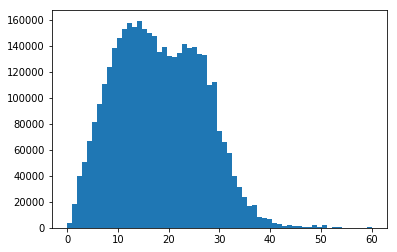

In [32]:
plt.hist(se['speed_mph'], range=(0, 60), bins=61);

In [33]:
se['mean_speed_mph_by_segment_code'] = se['line_distance']*1000/se['mean_durations_by_segment_code'] * 2.237

se['mean_speed_mph_by_segment_code_hour'] = se['line_distance']*1000/se['mean_durations_by_segment_code_and_hour'] * 2.237

se['speed_mph_diff_mean_to_hour'] = se['mean_speed_mph_by_segment_code_hour'] - se['mean_speed_mph_by_segment_code']


In [34]:
just_one = se[se['arrival_day'] < 5].groupby(["segment_name", "arrival_hour"]).first()

In [35]:
just_one = just_one.reset_index().merge(all_stats_df, left_on=['segment_name','arrival_hour'], right_on=['seg_name','hours']) # .set_index(['segment_name','arrival_hour'])

just_one = just_one.dropna(axis=0)

In [77]:
data_to_fit = just_one[['slow_fraction', 'fast_mean', 'total_mean',
                        'clipped_hmean','clipped_mean','freq',
                        'fast_hmean', 'line_distance', ]].values
#                         'direction_degrees', 'to_centre_dist']].values

poly = PolynomialFeatures(2)

expanded_data = poly.fit_transform(data_to_fit)

names = poly.get_feature_names(['slow_fraction', 'fast_mean', 'total_mean',
                                'clipped_hmean','clipped_mean','freq',
                                'fast_hmean','line_distance', ])
                                #'direction_degrees', 'to_centre_dist'])


In [157]:
def prep_training_data(data, target):

    cut_point = int(len(data)*3/4)
    
    train_data = data[:cut_point,:]
    test_data = data[cut_point:,:]
    
    test_mask = np.zeros(data.shape[0]).astype(bool)
    test_mask[cut_point:] = True

    train_target = target[:cut_point]
    test_target = target[cut_point:]
    
    scaler_target = preprocessing.StandardScaler().fit(train_target[:, None])

#     scaler_target = preprocessing.MinMaxScaler().fit(train_target[:, None])


    train_target_scaled = scaler_target.transform(train_target[:, None]).astype(np.float32)
    test_target_scaled = scaler_target.transform(test_target[:, None]).astype(np.float32)
    
    data_scaler = preprocessing.StandardScaler()

    train_data_scaled = data_scaler.fit_transform(train_data).squeeze()
    test_data_scaled = data_scaler.transform(test_data).squeeze()

    return train_data_scaled, test_data_scaled, train_target_scaled, test_target_scaled, scaler_target


4.862819762408351


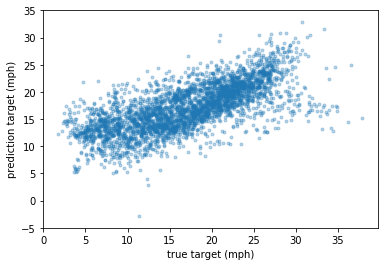

In [79]:
(train_data_scaled, test_data_scaled, 
 train_target_scaled, test_target_scaled, 
 scaler_target) = prep_training_data(expanded_data, just_one['mean_speed_mph_by_segment_code_hour'].values)

test_target_truth = scaler_target.inverse_transform(test_target_scaled).squeeze()

lr = LinearRegression()
# lr = Lasso()

lr.fit(train_data_scaled, train_target_scaled)

test_y_scaled = lr.predict(test_data_scaled)

test_y = scaler_target.inverse_transform(test_y_scaled)

test_target_truth = scaler_target.inverse_transform(test_target_scaled)

plt.scatter(test_target_truth, test_y, marker=".", alpha=0.3)
plt.xlabel("true target (mph)")
plt.ylabel("prediction target (mph)")
plt.ylim(-5,35)

print(np.sqrt(mean_squared_error(test_target_truth, test_y)))


In [52]:
ordered_names = np.array(names).squeeze()[np.argsort(np.abs(lr.coef_))].squeeze()

ordered_coef = np.array(lr.coef_).squeeze()[np.argsort(np.abs(lr.coef_))].squeeze()

display(list(zip(ordered_names, ordered_coef))[::-1])

[('fast_mean', -14.863527815755932),
 ('slow_fraction fast_mean', 9.374201087891013),
 ('total_mean', 8.824091028876069),
 ('clipped_mean fast_hmean', -7.834312978776891),
 ('fast_mean fast_hmean', 4.164133799597315),
 ('clipped_hmean fast_hmean', 3.2332654597705863),
 ('fast_mean clipped_hmean', -2.9824874857201893),
 ('total_mean fast_hmean', -2.870827822288181),
 ('clipped_mean^2', 2.8608408227289077),
 ('clipped_hmean', -2.6650625807171355),
 ('clipped_hmean clipped_mean', 2.2939402124960715),
 ('slow_fraction fast_hmean', -1.770326985840199),
 ('slow_fraction clipped_hmean', 1.490631143607167),
 ('fast_hmean', 1.4665651057843427),
 ('fast_hmean line_distance', 1.324937297620932),
 ('fast_hmean to_centre_dist', 1.132075869770856),
 ('freq fast_hmean', -1.1124550690503763),
 ('total_mean clipped_hmean', 1.078203136906096),
 ('total_mean clipped_mean', 0.9948674766723236),
 ('clipped_hmean to_centre_dist', -0.9414776674601439),
 ('clipped_mean', 0.9043478316189837),
 ('clipped_hmean 

In [40]:
(train_data_scaled, test_data_scaled, 
 train_target_scaled, test_target_scaled, 
 scaler_target) = prep_training_data(expanded_data, just_one['mean_speed_mph_by_segment_code_hour'].values)

ar = ARDRegression()
# lr = Lasso()

ar.fit(train_data_scaled, train_target_scaled)

test_y_scaled = ar.predict(test_data_scaled)

test_y = scaler_target.inverse_transform(test_y_scaled)

test_target_truth = scaler_target.inverse_transform(test_target_scaled)

print(np.sqrt(mean_squared_error(test_target_truth, test_y)))


/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


4.869489763387428


4.869489763387428


(-5, 35)

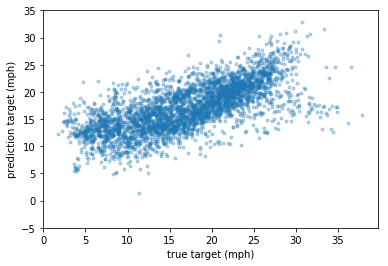

In [72]:
test_y_scaled = ar.predict(test_data_scaled)

test_y = scaler_target.inverse_transform(test_y_scaled)

test_target_truth = scaler_target.inverse_transform(test_target_scaled)

print(np.sqrt(mean_squared_error(test_target_truth, test_y)))

plt.scatter(test_target_truth, test_y, marker=".", alpha=0.3)
plt.xlabel("true target (mph)")
plt.ylabel("prediction target (mph)")
plt.ylim(-5,35)


In [41]:
ordered_names = np.array(names).squeeze()[np.argsort(np.abs(ar.coef_))].squeeze()

ordered_coef = np.array(ar.coef_).squeeze()[np.argsort(np.abs(ar.coef_))].squeeze()

display(list(zip(ordered_names, ordered_coef))[::-1])

[('fast_mean', -15.063008553221756),
 ('slow_fraction fast_mean', 9.332496285870562),
 ('total_mean', 9.012588583858312),
 ('clipped_mean fast_hmean', -5.094536375598904),
 ('clipped_mean^2', 2.5765495354650167),
 ('clipped_hmean fast_hmean', 1.9191818396563687),
 ('clipped_hmean^2', 1.7756833698541268),
 ('total_mean clipped_hmean', -1.613294161117751),
 ('fast_hmean line_distance', 1.519770873447014),
 ('clipped_hmean', -1.138333022535884),
 ('fast_mean fast_hmean', 1.1080322300938446),
 ('clipped_hmean line_distance', -1.0721193985343576),
 ('freq fast_hmean', -0.9695995589053193),
 ('clipped_hmean freq', 0.7380558192634924),
 ('clipped_mean', 0.7241022313281542),
 ('total_mean clipped_mean', 0.6733099396999003),
 ('freq', -0.6642990316367483),
 ('clipped_mean freq', 0.4410506279707755),
 ('slow_fraction^2', 0.34551353357338677),
 ('slow_fraction', -0.316752100651672),
 ('fast_mean clipped_mean', -0.3049182346137753),
 ('slow_fraction clipped_hmean', -0.2839144971427845),
 ('line_di

In [189]:
def create_simple_model(input_shape, dropout):

    # with help from: https://keras.io/getting-started/functional-api-guide/

    # Headline input: meant to receive road time series.
    main_input = Input(shape=[input_shape], dtype="float32", name="input")

    # We stack a deep densely-connected network on top
    x = Dense(128, activation="relu")(main_input)
    x = Dropout(rate=dropout)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(rate=dropout)(x)
    x = Dense(32, activation="relu")(x)
    x = Dropout(rate=dropout)(x)
    x = Dense(32, activation="relu")(x)
    x = Dropout(rate=dropout)(x)
    x = Dense(12, activation="relu")(x)
    x = Dropout(rate=dropout)(x)

    # And finally we add the main output layer
    main_output = Dense(1, activation="tanh", name="main_output")(x)

    model = Model(
        inputs=[main_input], outputs=[main_output]
    )

    model.summary()

    return model

In [81]:
(train_data_scaled, test_data_scaled, 
 train_target_scaled, test_target_scaled, 
 scaler_target) = prep_training_data(data_to_fit, just_one['mean_speed_mph_by_segment_code_hour'])

model = create_simple_model(
        (train_data_scaled.shape[1]),
        0.1)

Path(f"GPS_models").mkdir(parents=True, exist_ok=True)

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
    keras.callbacks.ModelCheckpoint(
        filepath=f"GPS_models/simple.h5",
        monitor="val_loss",
        save_best_only=True,
    ),
]

# model.compile(optimizer="rmsprop", loss="mean_absolute_error")
model.compile(optimizer="rmsprop", loss="mse")
model.fit(
    train_data_scaled,
    train_target_scaled,
    epochs=100,
    callbacks=callbacks_list,
    batch_size=32,
    validation_data=(test_data_scaled, test_target_scaled),
)

test_y_scaled = model.predict(test_data_scaled)

test_y = scaler_target.inverse_transform(test_y_scaled)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 8)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                288       
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 12)                396       
_________________________________________________________________
dropout_15 (Dropout)         (None, 12)                0         
__________

4.748011


(-5, 35)

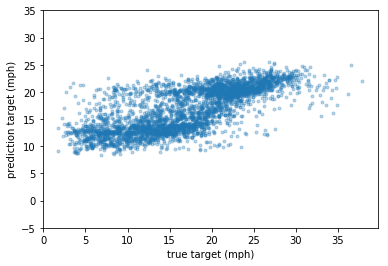

In [82]:
test_target_truth = scaler_target.inverse_transform(test_target_scaled).squeeze()

print(np.sqrt(mean_squared_error(test_target_truth, test_y)))

plt.scatter(test_target_truth, test_y, marker=".", alpha=0.3)
plt.xlabel("true target (mph)")
plt.ylabel("prediction target (mph)")
plt.ylim(-5,35)

### Plan

- Calc the stats for all the segments
- Load up the means by hour of the day and daytype for each of these segment names
- Try to find a way to predict the spead of the segment by hour using the stats
- Get the stats for each indivual event, not just the bulk averages, 
    - Do the same for the last hour on that segment and think about fast ways to do prev/next as well
- Try to find the stats with the highest and lowest variance (forcus on those with lower variance)
- See if you can then find outliers... 
- Is there enough data? 

In [114]:
segments_dict = {}

segments = filtered.groupby('segment_name')

for seg_name, segment in segments:
    
     df = segment.set_index("timeReported")['speed_mph']
        
     df.index = pd.to_datetime(df.index)
    
     segments_dict[seg_name] = df

In [ ]:
segments_dict['1200BOB20136_1200BOB20136']

In [263]:
matrix_width = 15

In [264]:
se_gps_data_hour = np.zeros((se.shape[0], matrix_width)).astype(np.float32)
se_gps_data_20mins = np.zeros((se.shape[0], matrix_width)).astype(np.float32)

In [265]:
se_gps_data_hour_prev_next = np.zeros((se.shape[0], matrix_width)).astype(np.float32)

In [266]:
for idx, row in enumerate(tqdm(se[['actualArrival', 'segment_name']].itertuples())):
    
    gps_tracks = segments_dict[row[2]]
    
    relevant = gps_tracks[(gps_tracks.index > row[1] - pd.Timedelta(f"80 min")) & (gps_tracks.index < row[1] - pd.Timedelta(f"20 min"))].values
    
    if(len(relevant) == 0):
        se_gps_data_hour[idx,0] = row[0]
        continue
    
    slow_count = np.count_nonzero(relevant < 3)
    fast = relevant[(relevant > 3)]
    clipped = relevant[(relevant > 3) & (relevant < 31)]
    
    row_data = np.empty(matrix_width).astype(np.float32)
    
    row_data[0] = row[0]
    row_data[1] = slow_count/len(relevant)
    row_data[2] = hmean(fast)
    row_data[3] = np.mean(fast)
    row_data[4] = np.mean(relevant)
    row_data[5] = hmean(clipped)
    row_data[6] = np.mean(clipped)
    row_data[7] = len(relevant)
    row_data[8] = len(fast)
    row_data[9] = len(clipped)

    if len(fast) > 0:
        row_data[10], row_data[11] = np.quantile(fast, [0.5, 0.75])
    else:
        row_data[10] = np.nan
        row_data[11] = np.nan
    
    row_data[12], row_data[13] = np.quantile(relevant, [0.5, 0.75])
    row_data[14] = np.max(relevant)
    
    se_gps_data_hour[idx, :] = row_data


/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/scipy/stats/stats.py:377: RuntimeWarning: invalid value encountered in double_scalars
  return size / np.sum(1.0 / a, axis=axis, dtype=dtype)
/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:13: Run

In [267]:
for idx, row in enumerate(tqdm(se[['actualArrival', 'segment_name']].itertuples())):
    
    gps_tracks = segments_dict[row[2]]
    
    relevant = gps_tracks[(gps_tracks.index > row[1] - pd.Timedelta(f"40 min")) & (gps_tracks.index < row[1] - pd.Timedelta(f"20 min"))].values
    
    if(len(relevant) == 0):
        se_gps_data_20mins[idx,0] = row[0]
        continue
    
    slow_count = np.count_nonzero(relevant < 3)
    fast = relevant[(relevant > 3)]
    clipped = relevant[(relevant > 3) & (relevant < 31)]
    
    row_data = np.empty(matrix_width).astype(np.float32)
    
    row_data[0] = row[0]
    row_data[1] = slow_count/len(relevant)
    row_data[2] = hmean(fast)
    row_data[3] = np.mean(fast)
    row_data[4] = np.mean(relevant)
    row_data[5] = hmean(clipped)
    row_data[6] = np.mean(clipped)
    row_data[7] = len(relevant)
    row_data[8] = len(fast)
    row_data[9] = len(clipped)
    
    if len(fast) > 0:
        row_data[10], row_data[11] = np.quantile(fast, [0.5, 0.75])
    else:
        row_data[10] = np.nan
        row_data[11] = np.nan
    
    row_data[12], row_data[13] = np.quantile(relevant, [0.5, 0.75])
    row_data[14] = np.max(relevant)

    
    se_gps_data_20mins[idx, :] = row_data
    

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]


In [268]:
for idx, row in enumerate(tqdm(se[['actualArrival', 'segment_name', 'prev_segment_name', 'next_segment_name']].itertuples())):
    
    gps_tracks = segments_dict[row[2]]
    
    relevant_current = gps_tracks[(gps_tracks.index > row[1] - pd.Timedelta(f"80 min")) & (gps_tracks.index < row[1] - pd.Timedelta(f"20 min"))].values.squeeze()
    
    if (row[3] != '') & (row[3] in segments_dict):
        gps_tracks_prev = segments_dict[row[3]]
        
        relevant_prev = gps_tracks_prev[(gps_tracks_prev.index > row[1] - pd.Timedelta(f"80 min")) & (gps_tracks_prev.index < row[1] - pd.Timedelta(f"20 min"))].values.squeeze()
    else:
        relevant_prev = [] 
        
    if (row[4] != '') & (row[4] in segments_dict):
        gps_tracks_next = segments_dict[row[4]]
    
        relevant_next = gps_tracks_next[(gps_tracks_next.index > row[1] - pd.Timedelta(f"80 min")) & (gps_tracks_next.index < row[1] - pd.Timedelta(f"20 min"))].values.squeeze()   
    else: 
        relevant_next = []
    
    relevant = np.concatenate(np.atleast_1d(relevant_current, relevant_prev, relevant_next))
    
    if(len(relevant) == 0):
        se_gps_data_hour_prev_next[idx,0] = row[0]
        continue
    
    slow_count = np.count_nonzero(relevant < 3)
    fast = relevant[(relevant > 3)]
    clipped = relevant[(relevant > 3) & (relevant < 31)]
    
    row_data = np.empty(matrix_width).astype(np.float32)
    
    row_data[0] = row[0]
    row_data[1] = slow_count/len(relevant)
    row_data[2] = hmean(fast)
    row_data[3] = np.mean(fast)
    row_data[4] = np.mean(relevant)
    row_data[5] = hmean(clipped)
    row_data[6] = np.mean(clipped)
    row_data[7] = len(relevant)
    row_data[8] = len(fast)
    row_data[9] = len(clipped)
    
    if len(fast) > 0:
        row_data[10], row_data[11] = np.quantile(fast, [0.5, 0.75])
    else:
        row_data[10] = np.nan
        row_data[11] = np.nan
    
    row_data[12], row_data[13] = np.quantile(relevant, [0.5, 0.75])
    row_data[14] = np.max(relevant)
    
    se_gps_data_hour_prev_next[idx, :] = row_data
    

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less


In [269]:
np.save("se_gps_features_20min_80min_2", se_gps_data_hour)
np.save("se_gps_features_20min_40min_2", se_gps_data_20mins)

In [270]:
np.save("se_gps_features_20min_80min_prev_next_2", se_gps_data_hour_prev_next)

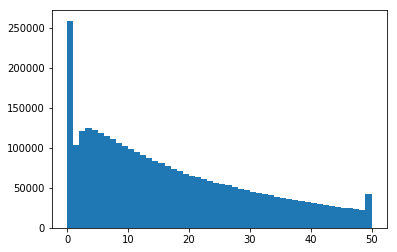

In [236]:
plt.hist(se_gps_data_hour_prev_next[:,7], bins=50, range=(0,50));

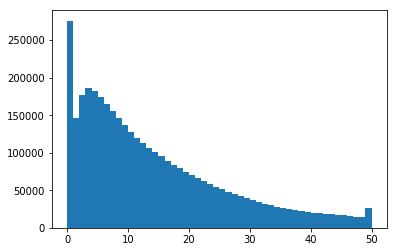

In [237]:
plt.hist(se_gps_data_hour_prev_next[:,8], bins=50, range=(0,50));

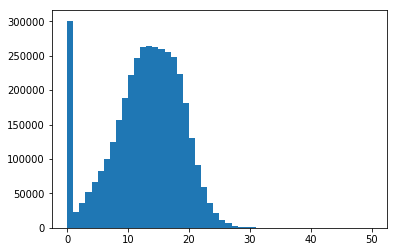

In [276]:
plt.hist(se_gps_data_hour_prev_next[:,13], bins=50, range=(0,50));

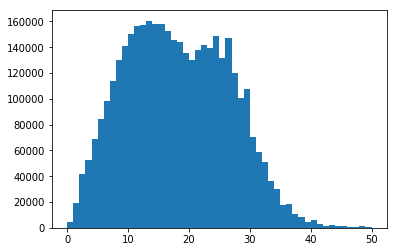

In [239]:
plt.hist(se['speed_mph'], bins=50, range=(0,50));

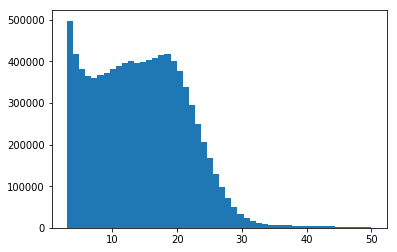

In [246]:
plt.hist(filtered['speed_mph'], bins=50, range=(3,50));

In [281]:
valid_mask = (se_gps_data_hour_prev_next[:,9] >= 3) & \
(se['speed_mph'] != np.inf) & \
(~np.isnan(se_gps_data_hour_prev_next[:,4])) & \
(~np.isnan(se_gps_data_hour_prev_next[:,10]))

In [282]:
(baseline_array_cum, 
 actual_array_cum, 
 baseline_median_array_cum, 
 baseline_pass_count, 
 pass_fraction, 
 baseline_median_pass_count, 
 median_pass_fraction) = calc_baseline_and_actual(se[valid_mask][int(len(se[valid_mask])*3/4):])

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in less


In [283]:
# valid_mask = (se_gps_data_hour_prev_next[:,9] >= 3) & 
# (se['speed_mph'] != np.inf) & 
# (~np.isnan(se_gps_data_hour_prev_next[:,4]) &
# (~np.isnan(se_gps_data_hour_prev_next[:,10]))

data = np.hstack((se_gps_data_hour_prev_next[:,1:], se[['line_distance', 'direction_degrees']].values))

(train_data_scaled, test_data_scaled, 
 train_target_scaled, test_target_scaled, 
 scaler_target) = prep_training_data(data[valid_mask], se[valid_mask]['speed_mph'])

model = create_simple_model(
        (train_data_scaled.shape[1]),
        0.1)

Path(f"GPS_models").mkdir(parents=True, exist_ok=True)

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
    keras.callbacks.ModelCheckpoint(
        filepath=f"GPS_models/simple_fulldata_[128,64,32,32,12]_logcosh.h5",
        monitor="val_loss",
        save_best_only=True,
    ),
]

# model.compile(optimizer="rmsprop", loss="mean_absolute_error")
model.compile(optimizer="rmsprop", loss="logcosh")
model.fit(
    train_data_scaled,
    train_target_scaled,
    epochs=100,
    callbacks=callbacks_list,
    batch_size=32,
    validation_data=(test_data_scaled, test_target_scaled),
)

test_y_scaled = model.predict(test_data_scaled)

test_y = scaler_target.inverse_transform(test_y_scaled)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 16)                0         
_________________________________________________________________
dense_62 (Dense)             (None, 128)               2176      
_________________________________________________________________
dropout_62 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_63 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_64 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_64 (Dropout)         (None, 32)                0         
__________

11.075286


(-5, 35)

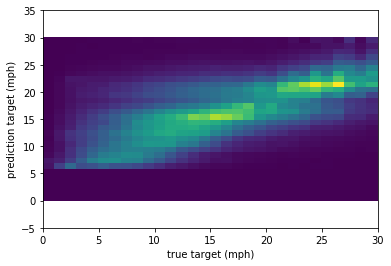

In [284]:
test_target_truth = scaler_target.inverse_transform(test_target_scaled).squeeze()

print(np.sqrt(mean_squared_error(test_target_truth, test_y)))

plt.hist2d(test_target_truth, test_y.squeeze(), range=[[0,30],[0,30]], bins=[30,30])
plt.xlabel("true target (mph)")
plt.ylabel("prediction target (mph)")
plt.ylim(-5,35)

In [285]:
predict_array_RNN_cum, _, pass_fraction = calc_prediction_cum_journeys(se[valid_mask][int(len(se[valid_mask])*3/4):], test_y.squeeze(), baseline_array_cum, actual_array_cum)
  

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in less


Approximately -14.76% improvment on baseline
Approximately 32.47% are in 10%


In [197]:
def percent_in_x_percent(predict, actual, threshold):
    
    if np.count_nonzero(~np.isnan(actual)) == 0:
        return 0, 0
    
    threshold = threshold/100
    
    mask = (~np.isnan(predict) & ~np.isnan(actual))
    
    pass_count = np.count_nonzero((predict[mask] < actual[mask] * (1 + threshold)) & (predict[mask] > actual[mask] * (1-threshold)))
    
    over_count = np.count_nonzero(predict[mask] > actual[mask] * (1+threshold))
    
    under_count = np.count_nonzero(predict[mask] < actual[mask] * (1-threshold))
    
    pass_percent = pass_count/np.count_nonzero(mask) * 100
    
    if over_count + under_count == 0:
        drift = 0.5
    else:
        drift = over_count / (over_count + under_count)
    
    return pass_percent, drift

def make_accuracy_matrix_minutes(predict, actual, max_threshold = 50):

    actual_ints = np.array(actual/60).astype(int)
    
    rows = int(max_threshold/10)
    
    max_a = np.nanmax(actual)/60

    accuracies_table = np.empty((rows, int(max_a)))
    drift_table = np.empty((rows, int(max_a)))
    frequency = np.empty(int(max_a))

    for i in range(int(max_a)):
        print(".", end="", flush=True)
        mask = (actual_ints == i)
        
        frequency[i] = np.count_nonzero(mask)
        
        for j in range(1, rows+1):
            accuracy, drift = percent_in_x_percent(predict[mask], actual[mask], j * 10)
            accuracies_table[j-1,i] = accuracy
            drift_table[j-1, i] = drift

    return accuracies_table, frequency, drift_table

def show_accuracy_minutes(predict, actual, title):
    results, frequency, drift = make_accuracy_matrix_minutes(predict, actual)
    
    for i in range(results.shape[0]):
        plt.plot(results[i,:], label=f"{(i+1)*10}%")
        
        
    plt.xlabel("minutes ahead")
    plt.ylabel("percentage within threshold")
    plt.legend()
    plt.title(title)
    plt.xlim(0,20)
    plt.ylim(0,100)
    plt.gca().yaxis.grid(True, linewidth="0.2")
    
    ax = plt.gca()
    
    ax2 = ax.twinx()
    ax2.plot(drift[0,:], label="fraction over", linestyle=":")
    ax2.set_ylim(0,1)
   
    plt.show()

In [198]:
# From: https://stackoverflow.com/questions/51597849/padding-a-numpy-array-with-offsets-for-each-data-column

def create_padded_array(a, row_start, n_rows):
    r = np.arange(n_rows)[:,None]
    row_start = np.asarray(row_start)
    mask = (r >= row_start) & (r < row_start+a.shape[0])

    out = np.zeros(mask.shape, dtype=a.dtype)
    out[:] = np.nan
    out.T[mask.T] = a.ravel('F')
    return out   

def create_triangle(input_array, max_width=70):
    
    filled_values = np.empty((input_array.shape[0],70)).astype(float)
    
    filled_values[:] = input_array[:,None]
    
    return create_padded_array(filled_values, list(range(70)), input_array.shape[0]+71)[:input_array.shape[0],:]
    
    
    

In [201]:
def calc_baseline_and_actual(data):
    
#     if len(calc_mask) == len(data_mask):
#         se_min = se[data_mask].copy()
#     else:
#         se_min = se[data_mask][calc_mask].copy()

    se_min = data.copy()
    
    baseline_array = np.empty((se_min.shape[0],70)).astype(float)
    baseline_array[:] = np.nan
    
    actual_array = np.empty((se_min.shape[0],70)).astype(float)
    actual_array[:] = np.nan
    
    baseline_median_array = np.empty((se_min.shape[0],70)).astype(float)
    baseline_median_array[:] = np.nan
    
    se_min = se_min.reset_index(drop=True)
    
    runs = se_min.groupby(['date','workid'])
    
    actual_index = se_min.columns.get_loc("segment_duration")
    baseline_index = se_min.columns.get_loc("mean_durations_by_segment_code_and_hour_and_day")
    baseline_median_index = se_min.columns.get_loc("median_durations_by_segment_code_and_hour_and_day")

    for name, run in runs:
        run = run.sort_values("actualArrival")
        
        baseline_array[run.index,:] = create_triangle(run.iloc[:, baseline_index])
        actual_array[run.index,:] = create_triangle(run.iloc[:, actual_index])
        baseline_median_array[run.index,:] = create_triangle(run.iloc[:, baseline_median_index])

#         run_length = len(run)

#         for i in range(min([run_length, 70])):
 
#             baseline_array[run.iloc[i:].index,i] = run.iloc[:run_length-i, baseline_index]

#             actual_array[run.iloc[i:].index,i] = run.iloc[:run_length-i, actual_index]
            
    baseline_array_cum = np.cumsum(baseline_array, axis=1)
    actual_array_cum = np.cumsum(actual_array, axis=1)
    baseline_median_array_cum = np.cumsum(baseline_median_array, axis=1)
    
    actual_array_cum = np.clip(actual_array_cum, 0, 2*60*60)
    
    first_20mins_mask = actual_array_cum < 20*60
    
    baseline_pass_count = np.count_nonzero((baseline_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (baseline_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    pass_fraction = baseline_pass_count/np.count_nonzero(first_20mins_mask)
    
    baseline_median_pass_count = np.count_nonzero((baseline_median_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (baseline_median_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    median_pass_fraction = baseline_median_pass_count/np.count_nonzero(first_20mins_mask)
    
    return baseline_array_cum, actual_array_cum, baseline_median_array_cum, baseline_pass_count, pass_fraction, baseline_median_pass_count, median_pass_fraction


In [209]:
def calc_prediction_cum_journeys(data, speeds_mph, baseline_array_cum, actual_array_cum):
    
#     if len(calc_mask) == len(data_mask):
#         se_min = se[data_mask].copy()
#     else:
#         se_min = se[data_mask][calc_mask].copy()

    se_min = data.copy()
      
    se_min['prediction'] = se_min['line_distance'] * 1000 / speeds_mph * 2.237
    
    predict_array = np.empty((se_min.shape[0],70)).astype(float)
    predict_array[:] = np.nan
    
    se_min = se_min.reset_index(drop=True)
    
    runs = se_min.groupby(['date','workid'])
    
    prediction_index = se_min.columns.get_loc("prediction")
    
    for name, run in runs:
        run = run.sort_values("actualArrival")
        
        predict_array[run.index,:] = create_triangle(run.iloc[:, prediction_index])

#         run_length = len(run)

#         for i in range(min([run_length, 70])):

#             predict_array[run.iloc[i:].index,i] = run.iloc[:run_length-i, prediction_index]
            
    predict_array_cum = np.cumsum(predict_array, axis=1)
    
    first_20mins_mask = actual_array_cum < 20*60
    
    baseline_pass_count = np.count_nonzero((baseline_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (baseline_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    
    pass_count = np.count_nonzero((predict_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (predict_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    pass_fraction = pass_count/np.count_nonzero(first_20mins_mask)
        
    print(f"Approximately {(pass_count - baseline_pass_count)/baseline_pass_count*100:0.2f}% improvment on baseline")
    
    print(f"Approximately {pass_fraction*100:0.2f}% are in 10%")
    
    return predict_array_cum, pass_count, pass_fraction
    